In [26]:
# https://github.com/mingyue-cheng/timemae

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import torch
import torch.nn.functional as F
import tqdm
import random

from collections import namedtuple
from torch import nn
from einops import rearrange, repeat, pack, unpack
from einops.layers.torch import Rearrange
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.init import xavier_normal_, uniform_, constant_

In [2]:
ecg_mat = scipy.io.loadmat('ECGData.mat')

In [3]:
ecg_data = ecg_mat['ECGData'][0][0][0]
print(ecg_data.shape)

(162, 65536)


In [4]:
labels = ecg_mat['ECGData'][0][0][1]
print(labels.shape)

(162, 1)


In [5]:
def split_dataset_indices(N, train_percent, val_percent, test_percent, seed=42):
    # Validate input percentages
    if train_percent + val_percent + test_percent != 100:
        raise ValueError("The sum of the percentages must be 100.")

    random.seed(seed)
    # Generate a list of indices
    indices = list(range(N))
    random.shuffle(indices)

    # Calculate split sizes
    train_size = int((train_percent / 100) * N)
    val_size = int((val_percent / 100) * N)

    # Split indices
    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size + val_size]
    test_indices = indices[train_size + val_size:]

    return train_indices, val_indices, test_indices

In [6]:
train_indices, val_indices, test_indices = split_dataset_indices(labels.shape[0], 70, 15, 15)

In [28]:
def create_windowed_dataset(data, labels, window_size=1024, stride=None):
    if not stride:
        stride = window_size

    min_val = np.min(data, axis=(0, 1), keepdims=True)
    max_val = np.max(data, axis=(0, 1), keepdims=True)
    data = 2 * ((data - min_val) / (max_val - min_val)) - 1
    
    num_samples, sample_size = data.shape
    num_windows = sample_size // window_size
    
    # Initialize the windowed data and label arrays
    windowed_data = np.empty((num_samples * num_windows, window_size))
    windowed_labels = np.empty((num_samples * num_windows, 1), dtype=labels.dtype)

    for i in range(num_samples):
        for j in range(num_windows):
            start = j * stride
            end = start + window_size
            windowed_data[i * num_windows + j, :] = data[i, start:end]
            windowed_labels[i * num_windows + j, :] = labels[i]

    #windowed_data = np.expand_dims(windowed_data, 1)
    return torch.tensor(windowed_data, dtype=torch.float32), windowed_labels

In [29]:
ecg_t, labels_t = create_windowed_dataset(ecg_data[train_indices], labels[train_indices], window_size=1024)
ecg_v, labels_v = create_windowed_dataset(ecg_data[val_indices], labels[val_indices], window_size=1024)

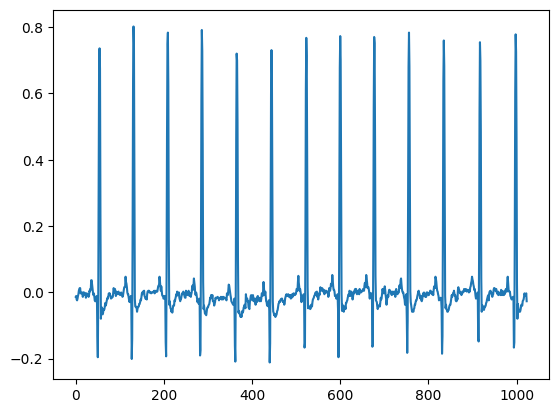

In [31]:
plt.plot(ecg_v[0])

In [43]:
list(ecg_t.shape)

[7232, 1024]

## MAE stuff

In [53]:
from timemae.loss import CE, Align, Reconstruct
from timemae.model.layers import TransformerBlock, PositionalEmbedding, CrossAttnTRMBlock

In [49]:
class Encoder(nn.Module):
    def __init__(self, d_model, attn_heads, layers, dropout, enable_res_parameter):
        super(Encoder, self).__init__()
        d_model = d_model
        attn_heads = attn_heads
        d_ffn = 4 * d_model
        layers = layers
        dropout = dropout
        enable_res_parameter = enable_res_parameter
        # TRMs
        self.TRMs = nn.ModuleList(
            [TransformerBlock(d_model, attn_heads, d_ffn, enable_res_parameter, dropout) for i in range(layers)])

    def forward(self, x):
        for TRM in self.TRMs:
            x = TRM(x, mask=None)
        return x


class Tokenizer(nn.Module):
    def __init__(self, rep_dim, vocab_size):
        super(Tokenizer, self).__init__()
        self.center = nn.Linear(rep_dim, vocab_size)

    def forward(self, x):
        bs, length, dim = x.shape
        probs = self.center(x.view(-1, dim))
        ret = F.gumbel_softmax(probs)
        indexes = ret.max(-1, keepdim=True)[1]
        return indexes.view(bs, length)


class Regressor(nn.Module):
    def __init__(self, d_model, attn_heads, d_ffn, enable_res_parameter, layers):
        super(Regressor, self).__init__()
        self.layers = nn.ModuleList(
            [CrossAttnTRMBlock(d_model, attn_heads, d_ffn, enable_res_parameter) for i in range(layers)])

    def forward(self, rep_visible, rep_mask_token):
        for TRM in self.layers:
            rep_mask_token = TRM(rep_visible, rep_mask_token)
        return rep_mask_token


class TimeMAE(nn.Module):
    def __init__(self, data_shape, d_model, momentum=0.99, linear_proba, device='cpu', max_len, mask_len, position):
        super(TimeMAE, self).__init__()
        d_model = args.d_model

        self.momentum = args.momentum
        self.linear_proba = True
        self.device = args.device
        self.data_shape = args.data_shape
        self.max_len = int(self.data_shape[0] / args.wave_length)
        print(self.max_len)
        self.mask_len = int(args.mask_ratio * self.max_len)
        self.position = PositionalEmbedding(self.max_len, d_model)

        self.mask_token = nn.Parameter(torch.randn(d_model, ))
        self.input_projection = nn.Conv1d(args.data_shape[1], d_model, kernel_size=args.wave_length,
                                          stride=args.wave_length)
        self.encoder = Encoder(args)
        self.momentum_encoder = Encoder(args)
        self.tokenizer = Tokenizer(d_model, args.vocab_size)
        self.reg = Regressor(d_model, args.attn_heads, 4 * d_model, 1, args.reg_layers)
        self.predict_head = nn.Linear(d_model, args.num_class)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            xavier_normal_(module.weight.data)
            if module.bias is not None:
                constant_(module.bias.data, 0.1)

    def copy_weight(self):
        with torch.no_grad():
            for (param_a, param_b) in zip(self.encoder.parameters(), self.momentum_encoder.parameters()):
                param_b.data = param_a.data

    def momentum_update(self):
        with torch.no_grad():
            for (param_a, param_b) in zip(self.encoder.parameters(), self.momentum_encoder.parameters()):
                param_b.data = self.momentum * param_b.data + (1 - self.momentum) * param_a.data

    def pretrain_forward(self, x):
        x = self.input_projection(x.transpose(1, 2)).transpose(1, 2).contiguous()
        tokens = self.tokenizer(x)
        x += self.position(x)
        rep_mask_token = self.mask_token.repeat(x.shape[0], x.shape[1], 1) + self.position(x)

        index = np.arange(x.shape[1])
        random.shuffle(index)
        v_index = index[:-self.mask_len]
        m_index = index[-self.mask_len:]
        visible = x[:, v_index, :]
        mask = x[:, m_index, :]
        tokens = tokens[:, m_index]
        rep_mask_token = rep_mask_token[:, m_index, :]

        rep_visible = self.encoder(visible)
        with torch.no_grad():
            # rep_mask = self.encoder(mask)
            rep_mask = self.momentum_encoder(mask)
        rep_mask_prediction = self.reg(rep_visible, rep_mask_token)
        token_prediction_prob = self.tokenizer.center(rep_mask_prediction)

        return [rep_mask, rep_mask_prediction], [token_prediction_prob, tokens]

    def forward(self, x):
        if self.linear_proba:
            with torch.no_grad():
                x = self.input_projection(x.transpose(1, 2)).transpose(1, 2).contiguous()
                x += self.position(x)
                x = self.encoder(x)
                return torch.mean(x, dim=1)
        else:
            x = self.input_projection(x.transpose(1, 2)).transpose(1, 2).contiguous()
            x += self.position(x)
            x = self.encoder(x)
            return self.predict_head(torch.mean(x, dim=1))

    def get_tokens(self, x):
        x = self.input_projection(x.transpose(1, 2)).transpose(1, 2).contiguous()
        tokens = self.tokenizer(x)
        return tokens


In [50]:
# Function to create batches - returns a DataLoader
def create_batches(data, batch_size):
    tensor_data = torch.Tensor(data)
    dataset = TensorDataset(tensor_data)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Function to determine the tqdm environment
def get_tqdm():
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return tqdm.notebook.tqdm
        else:
            return tqdm.tqdm
    except NameError:
        return tqdm.tqdm

# Training loop
def train_model(train_data, val_data, batch_size, num_epochs, model, optimizer):
    # Use the appropriate tqdm version
    tqdm_bar = get_tqdm()

    # Create batches
    dataloader = create_batches(train_data, batch_size)

    for epoch in range(num_epochs):
        total_loss, num_batches = 0, 0
        with tqdm_bar(total=len(dataloader), desc=f'Epoch {epoch + 1}/{num_epochs}') as pbar:
            for data_batch in dataloader:
                loss, _, _, _ = mae(data_batch[0])
                loss.backward()

                optimizer.step()
                optimizer.zero_grad()

                total_loss += loss.item()
                num_batches += 1

                average_loss = total_loss / num_batches
                pbar.set_postfix(avg_loss=average_loss)
                pbar.update()
            with torch.no_grad():
                loss_v, patches_v, masked_indices_v, pred_pixel_values_v = mae(val_data)
                plot_example(patches_v, masked_indices_v, pred_pixel_values_v, 0)
                pbar.set_postfix(train_loss=average_loss, val_loss=loss_v.detach().numpy())

In [51]:
model = TimeMAE(model_args)

TypeError: unsupported operand type(s) for /: 'int' and '_collections._tuplegetter'